# VGG

This notebook is an implement of [___Very Deep Convolutional Networks for Large-Scale Image Recognition___](https://arxiv.org/pdf/1409.1556.pdf) by Simonyan et al. The original model was trained for ImageNet dataset, but in this notebook we fine-tuned it for Cifar 10 dataset, which is a relatively smaller dataset and is better to store on Google Colab. 

We first need to install and import all the dependent libraries in the session.

In [ ]:
!pip install tensorflow tensorflow-datasets keras-tuner matplotlib sklearn

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

     |████████████████████████████████| 97 kB 5.5 MB/s 
Mounted at /content/drive


This is function that constructs a VGG model. We provide VGG with layers 11, 13, 16, and 19, which are provided in the paper. The structure of the model is almost same with the original paper, but the kernel size and strides are adjusted to fit the smaller pictures of Cifar 10. We define two variables, weight_decay and dropout_rate, as the hyperparameters of the model for kernel regularization and dropout layer, respectively.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2

def add_layer(model, num_filters, num_layers, weight_decay, dropout_rate):
    for i in range(num_layers):
        model.add(Conv2D(filters = num_filters, kernel_size = (3, 3), activation = "relu", padding = "same",
            kernel_regularizer = l2(weight_decay)))
        model.add(BatchNormalization())

        if i < num_layers - 1:
            model.add(Dropout(rate = dropout_rate))

    model.add(MaxPooling2D(pool_size = 2, strides = 2))

def createVGG(type, weight_decay, dropout_rate):
    if type == 11:
        params = [1, 1, 2, 2, 2]
    elif type == 13:
        params = [2, 2, 2, 2, 2]
    elif type == 16:
        params = [2, 2, 3, 3, 3]
    elif type == 19:
        params = [2, 2, 4, 4, 4]
    else:
        raise Exception("The parameter is not valid!")

    model = tf.keras.Sequential()

    model.add(InputLayer(input_shape = (32, 32, 3)))
    add_layer(model, 64, params[0], weight_decay, dropout_rate)
    add_layer(model, 128, params[1], weight_decay, dropout_rate)
    add_layer(model, 256, params[2], weight_decay, dropout_rate)
    add_layer(model, 512, params[3], weight_decay, dropout_rate)
    add_layer(model, 512, params[4], weight_decay, dropout_rate)

    model.add(Flatten());
    model.add(Dense(512, activation = "relu", kernel_regularizer = l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(10, activation = "softmax"))

    return model

In this part of the program, we get the Cifar 10 dataset using tensorflow dataset and separate it into training set and test set.

In [ ]:
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

def get_data():
    data, label = tfds.as_numpy(
        tfds.load("cifar10", split = "train", shuffle_files = True, as_supervised = True, batch_size = -1))

    return train_test_split(data, label, test_size = .2, random_state = 4)

This part trains the VGG model on Cifar 10 dataset. We tested several sets of hyperparameters and adopted one with the best validation loss. We then store the best weights of each training epochs on drive so that we can continue training even if the session disconnects. We also store searching results and training weights in case the process takes too much time or the session crashes accidentally. We show the result of the training process with a graph about the training and validation accuracy for each epoch. 

Epoch 1/200
500/500 [==============================] - 22s 38ms/step - loss: 7189.0908 - accuracy: 0.1050 - val_loss: 6040.9360 - val_accuracy: 0.1086
Epoch 2/200
500/500 [==============================] - 18s 37ms/step - loss: 5159.2729 - accuracy: 0.1084 - val_loss: 4379.6226 - val_accuracy: 0.1101
Epoch 3/200
500/500 [==============================] - 18s 37ms/step - loss: 3774.8293 - accuracy: 0.1131 - val_loss: 3235.8706 - val_accuracy: 0.1046
Epoch 4/200
500/500 [==============================] - 18s 37ms/step - loss: 2809.4744 - accuracy: 0.1157 - val_loss: 2424.9121 - val_accuracy: 0.1042
Epoch 5/200
500/500 [==============================] - 18s 37ms/step - loss: 2112.7754 - accuracy: 0.1276 - val_loss: 1827.3334 - val_accuracy: 0.1205
Epoch 6/200
500/500 [==============================] - 18s 37ms/step - loss: 1589.9342 - accuracy: 0.1621 - val_loss: 1371.0404 - val_accuracy: 0.1234
Epoch 7/200
500/500 [==============================] - 18s 37ms/step - loss: 1186.1937 - accur

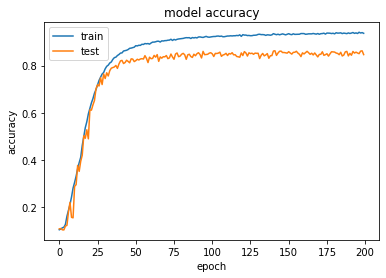

In [ ]:
# Set a checkpoint to save weights
cp = tf.keras.callbacks.ModelCheckpoint("weights", monitor = "loss", verbose = 1, save_best_only = True, mode = "auto")

train_x, _, train_y, _ = get_data()
model = createVGG(19, 1.5, .3)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics = ["accuracy"])

# We can use the existing data if the training process has started
# model.load_weights("weights") 

history = model.fit(train_x, train_y, epochs = 200, validation_split = .2, batch_size = 64)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

Here we test our model on test set and show how VGG predicts on sample images in the test set.

Test Accuracy: 85.68%


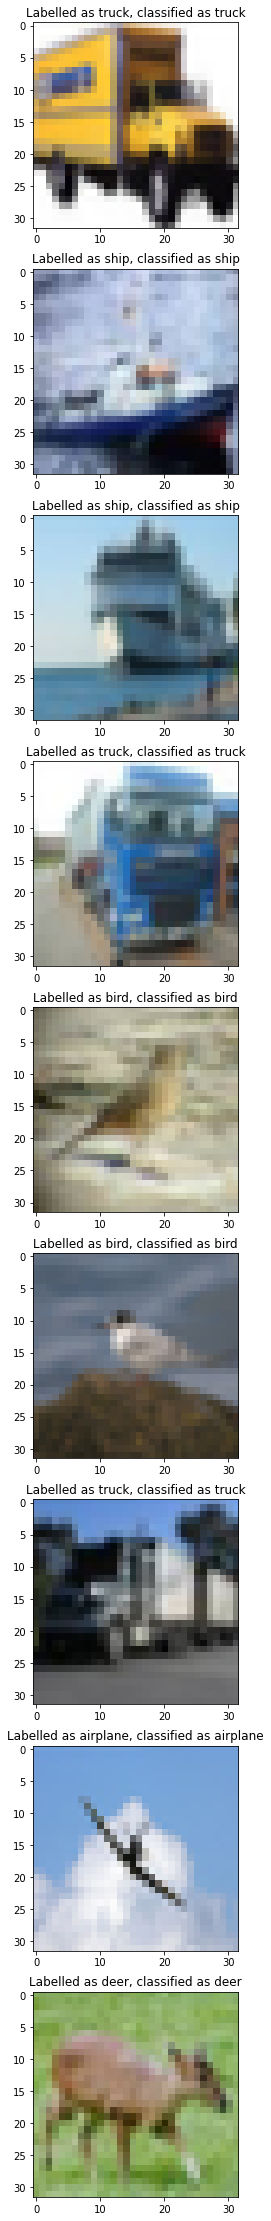

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

_, test_x, _, test_y = get_data()

pred = np.argmax(model.predict(test_x), axis = 1)

print("Test Accuracy: {:.2%}".format(np.sum(pred == test_y) / len(test_y)))

sample_data = test_x[: 9]
sample_label = test_y[: 9]

fig = plt.figure(figsize = (10, 40))

for i in range(len(sample_data)):
    ax = fig.add_subplot(911 + i)
    ax.imshow(test_x[i])

    ax.set_title("Labelled as " + labels[int(sample_label[i])] + ", classified as " + labels[int(pred[i])])